In [7]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
#  FUNCTIONS
# -----------------------------

# relativistic frequencies
def nu_phi(R, a):
    return 1.0 / (R**1.5 + a)

def nu_theta(R, a):
    return nu_phi(R, a) * np.sqrt(1 - 4*a/R**1.5 + 3*a**2/R**2)

def nu_LT(R, a):
    return nu_phi(R, a) - nu_theta(R, a)

# Kerr ISCO radius
def r_isco(a):
    if a==0:
        return 6
    Z1 = 1 + (1 - a**2)**(1/3) * ((1 + a)**(1/3) + (1 - a)**(1/3))
    Z2 = np.sqrt(3*a**2 + Z1**2)
    return 3 + Z2 - abs(a)/a*np.sqrt((3 - Z1)*(3 + Z1 + 2*Z2))


def nu_prec_vectorized(a, rin, rout, zeta, n_rad=2000):
    """
    Vectorized relativistic solid-body precession frequency.
    Works for any broadcastable shapes, including scalars.
    """

    # Convert inputs to numpy arrays
    a    = np.asarray(a)
    rin  = np.asarray(rin)
    rout = np.asarray(rout)
    zeta = np.asarray(zeta)

    # Ensure correct number of dimensions for broadcasting
    a    = np.atleast_1d(a)
    rin  = np.atleast_1d(rin)
    rout = np.atleast_1d(rout)
    zeta = np.atleast_1d(zeta)

    # Build x grid
    x = np.linspace(0, 1, n_rad)
    x = x.reshape((1,) * a.ndim + (n_rad,))

    # Reconstruct R
    R = rin[..., None] + x * (rout - rin)[..., None]

    # Compute integrand
    Sigma = R**(-zeta[..., None])
    weight = Sigma * R**3 * nu_phi(R, a[..., None])

    num = np.trapezoid(nu_LT(R, a[..., None]) * weight, x, axis=-1)
    den = np.trapezoid(weight, x, axis=-1)

    return num / den



# Numerical integral version (your "true" frequency)
def nu_prec_numeric(a, r_in, r_out, zeta, n_rad=500):
    R = np.linspace(r_in, r_out, n_rad)
    Sigma = R**(-zeta)
    weight = Sigma * R**3 * nu_phi(R, a)

    num = np.trapezoid(nu_LT(R, a) * weight, R)
    den = np.trapezoid(weight, R)

    return num / den  # geometric units


# -----------------------------
#  PARAMETERS
# -----------------------------



# -----------------------------
#  COMPUTE BOTH FREQUENCIES
# -----------------------------

"""
a_range = np.linspace(-95, 95, 191)  # Spins
a_range = a_range/100
a_range = np.insert(a_range, 0, -0.998)  # add extreme retrograde spin
a_range = np.append(a_range, 0.998)      # add extreme prograde spin

r_in_list = []
for a in a_range:
    r0 = r_isco(a)
    rvals = np.exp(np.linspace(np.log(r0), np.log(75), 75))  #5e2, 200
    r_in_list.append(rvals)
# stack into (Na, Nr)
r_in_grid = np.array(r_in_list)

# build r_out grid for all spins & all r_in
r_out_list = []
for i, a in enumerate(a_range):
    row = []
    for rin in r_in_grid[i]:
        rvals = np.exp(np.linspace(np.log(rin*1.05), np.log(250), 250))
        row.append(rvals)
    r_out_list.append(row)
r_out_grid = np.array(r_out_list)  # shape (Na, Nr_in, Nr_out)

zetas = np.array([-0.45, 0, 0.5])

A     = a_range[:, None, None, None]      # (Na,1,1,1)
RIN   = r_in_grid[:, :, None, None]       # (Na,Nr,1,1)
ROUT  = r_out_grid[:, :, :, None]         # (Na,Nr,No,1)
ZETA  = zetas[None, None, None, :]        # (1,1,1,Nz)

nu_approx = nu_prec_vectorized(A, RIN, ROUT, ZETA)  # (Na,Nr,No,Nz)
"""


'\na_range = np.linspace(-95, 95, 191)  # Spins\na_range = a_range/100\na_range = np.insert(a_range, 0, -0.998)  # add extreme retrograde spin\na_range = np.append(a_range, 0.998)      # add extreme prograde spin\n\nr_in_list = []\nfor a in a_range:\n    r0 = r_isco(a)\n    rvals = np.exp(np.linspace(np.log(r0), np.log(75), 75))  #5e2, 200\n    r_in_list.append(rvals)\n# stack into (Na, Nr)\nr_in_grid = np.array(r_in_list)\n\n# build r_out grid for all spins & all r_in\nr_out_list = []\nfor i, a in enumerate(a_range):\n    row = []\n    for rin in r_in_grid[i]:\n        rvals = np.exp(np.linspace(np.log(rin*1.05), np.log(250), 250))\n        row.append(rvals)\n    r_out_list.append(row)\nr_out_grid = np.array(r_out_list)  # shape (Na, Nr_in, Nr_out)\n\nzetas = np.array([-0.45, 0, 0.5])\n\nA     = a_range[:, None, None, None]      # (Na,1,1,1)\nRIN   = r_in_grid[:, :, None, None]       # (Na,Nr,1,1)\nROUT  = r_out_grid[:, :, :, None]         # (Na,Nr,No,1)\nZETA  = zetas[None, None, Non

In [8]:
a     = 0.5      # spin
r_in  = 6.0      # fixed inner radius
zeta  = 0.0      # density slope
M_bh  = 10       # solar masses, used only if converting Hz (not needed here)

# Sweep outer radius
r_out_vals = np.linspace(1.05 * r_in, 200, 200)

In [9]:
for a in [-0.998, -0.5, 0.0, 0.5, 0.998]:
    nu_approx = np.array([nu_prec_vectorized(a, r_in, ro, zeta) for ro in r_out_vals])


In [11]:
for a in [-0.998, -0.5, 0.0, 0.5, 0.998]:
    nu_true   = np.array([nu_prec_numeric(a, r_in, ro, zeta) for ro in r_out_vals])

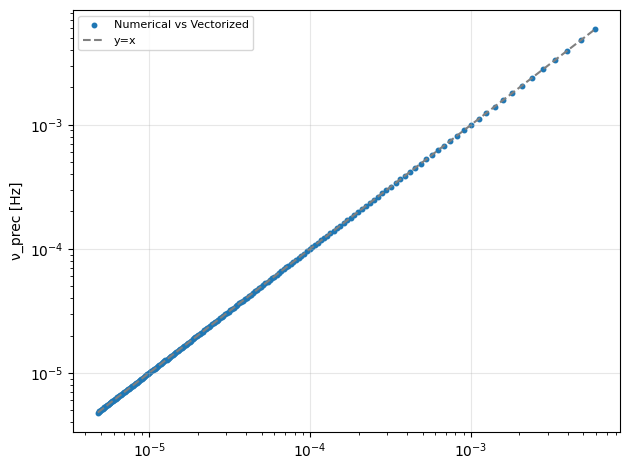

In [13]:
#plt.plot(r_out_vals, nu_true,   label="Numerical (trapezoidal)", lw=2)
#plt.plot(r_out_vals, nu_approx, label="Vectorized formula", ls="--", lw=2)
plt.scatter(nu_true, nu_approx, label="Numerical vs Vectorized", lw=2, s=5)
plt.plot([min(nu_true.min(), nu_approx.min()), max(nu_true.max(), nu_approx.max())],
         [min(nu_true.min(), nu_approx.min()), max(nu_true.max(), nu_approx.max())],
         ls="--", color="gray", label="y=x")

#plt.title(f"Precession frequency vs r_out   (zeta = {zeta})")
#plt.xlabel("r_out [Rg]")
plt.ylabel("ν_prec [Hz]")
plt.xscale("log")
plt.yscale("log")
plt.grid(True, alpha=0.3)
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import time

# --------------------------------------------------------
# FREQUENCIES
# --------------------------------------------------------

def nu_phi(R, a):
    return 1.0 / (R**1.5 + abs(a))

def nu_theta(R, a):
    return nu_phi(R, a) * np.sqrt(1 - 4*abs(a)/R**1.5 + 3*a**2/R**2)

def nu_LT(R, a):
    return nu_phi(R, a) - nu_theta(R, a)


# --------------------------------------------------------
# NUMERIC TRUE INTEGRATION
# --------------------------------------------------------

def nu_prec_numeric(a, r_in, r_out, zeta, n_rad=50000):
    R = np.linspace(r_in, r_out, n_rad)
    Sigma = R**(-zeta)
    weight = Sigma * R**3 * nu_phi(R, a)

    num = np.trapezoid(nu_LT(R, a) * weight, R)
    den = np.trapezoid(weight, R)

    return num / den


# --------------------------------------------------------
# VECTORIZED APPROXIMATE VERSION
# (fixed version that works for scalars)
# --------------------------------------------------------

def nu_prec_vectorized(a, rin, rout, zeta, n_rad=2000):
    a    = np.atleast_1d(a)
    rin  = np.atleast_1d(rin)
    rout = np.atleast_1d(rout)
    zeta = np.atleast_1d(zeta)

    x = np.linspace(0, 1, n_rad)
    x = x.reshape((1,) * a.ndim + (n_rad,))

    R = rin[..., None] + x * (rout - rin)[..., None]

    Sigma  = R**(-zeta[..., None])
    weight = Sigma * R**3 * nu_phi(R, a[..., None])

    num = np.trapezoid(nu_LT(R, a[..., None]) * weight, x, axis=-1)
    den = np.trapezoid(weight, x, axis=-1)

    return (num / den).squeeze()


# --------------------------------------------------------
# BENCHMARK PARAMETERS
# --------------------------------------------------------

a     = 0.5
r_in  = 6.0
zeta  = 10

# scan over outer radius
r_out_vals = np.linspace(1.05*r_in, 200, 200)



Benchmark completed
Average numeric time:     0.0042 s
Average vectorized time:  0.0003 s
Speed-up factor:          14.6x


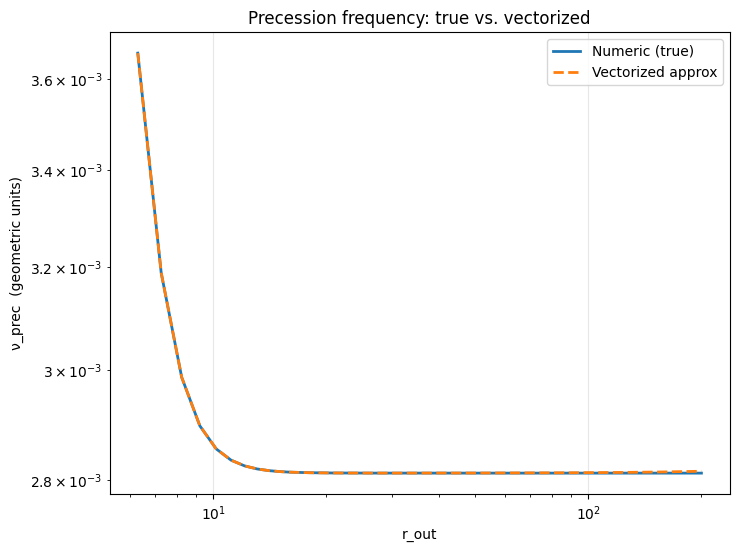

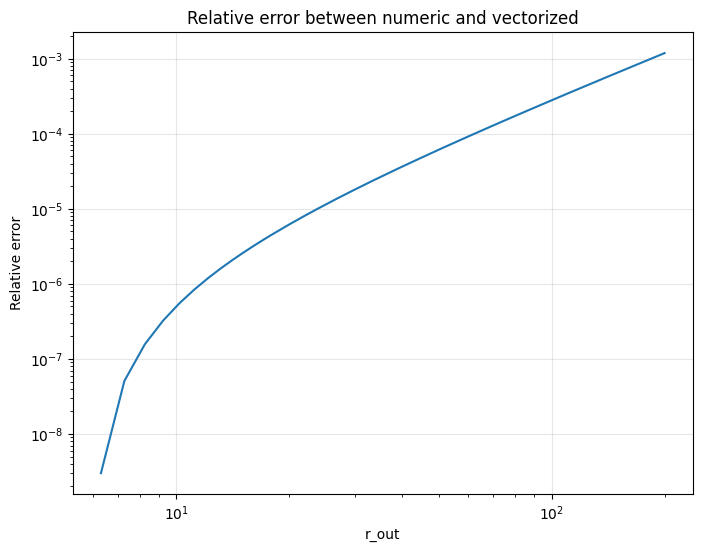

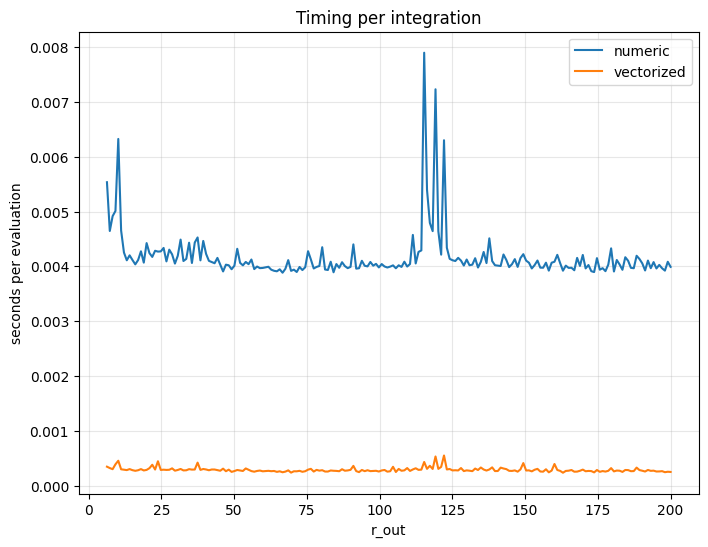

In [33]:

# --------------------------------------------------------
# RUN BENCHMARK
# --------------------------------------------------------

nu_true   = np.zeros_like(r_out_vals)
nu_approx = np.zeros_like(r_out_vals)

t_num = []
t_vec = []

for i, r_out in enumerate(r_out_vals):

    # numeric
    t0 = time.perf_counter()
    nu_true[i] = nu_prec_numeric(a, r_in, r_out, zeta)
    t_num.append(time.perf_counter() - t0)

    # vectorized
    t0 = time.perf_counter()
    nu_approx[i] = nu_prec_vectorized(a, r_in, r_out, zeta)
    t_vec.append(time.perf_counter() - t0)


# --------------------------------------------------------
# COMPUTE ERROR
# --------------------------------------------------------

rel_err = np.abs(nu_true - nu_approx) / nu_true


# --------------------------------------------------------
# PRINT SPEEDUP
# --------------------------------------------------------

print("\nBenchmark completed")
print(f"Average numeric time:     {np.mean(t_num):.4f} s")
print(f"Average vectorized time:  {np.mean(t_vec):.4f} s")
print(f"Speed-up factor:          {np.mean(t_num)/np.mean(t_vec):.1f}x")


# --------------------------------------------------------
# PLOTS
# --------------------------------------------------------

plt.figure(figsize=(8,6))
plt.loglog(r_out_vals, nu_true, label="Numeric (true)", lw=2)
plt.loglog(r_out_vals, nu_approx, "--", label="Vectorized approx", lw=2)
plt.xlabel("r_out")
plt.ylabel("ν_prec  (geometric units)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.title("Precession frequency: true vs. vectorized")
plt.show()

plt.figure(figsize=(8,6))
plt.loglog(r_out_vals, rel_err)
plt.xlabel("r_out")
plt.ylabel("Relative error")
plt.grid(True, alpha=0.3)
plt.title("Relative error between numeric and vectorized")
plt.show()

plt.figure(figsize=(8,6))
plt.plot(r_out_vals, t_num, label="numeric")
plt.plot(r_out_vals, t_vec, label="vectorized")
plt.xlabel("r_out")
plt.ylabel("seconds per evaluation")
plt.grid(True, alpha=0.3)
plt.legend()
plt.title("Timing per integration")
plt.show()

/tmp/ipykernel_654/1276269063.py:49: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  nu_true2[i] = nu_prec_numeric_vectorized(a, r_in, r_out, zeta)



Benchmark completed
Average numeric time:     0.0018 s
Average vectorized time:  0.0003 s
Speed-up factor:          6.2x


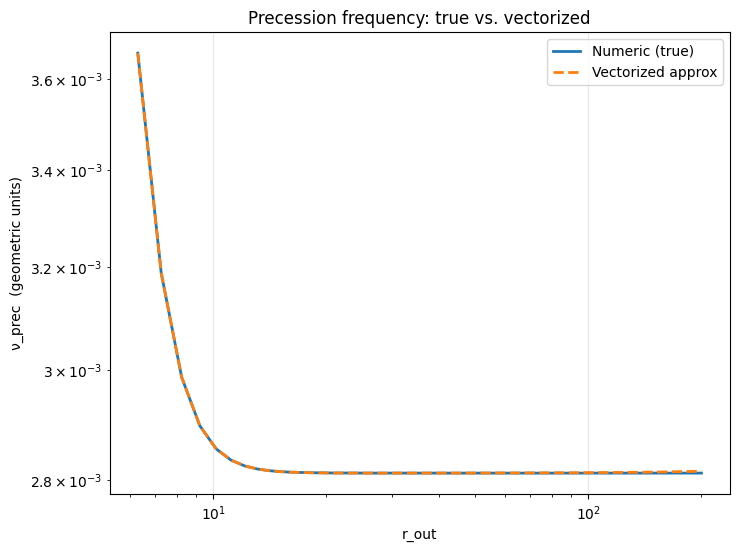

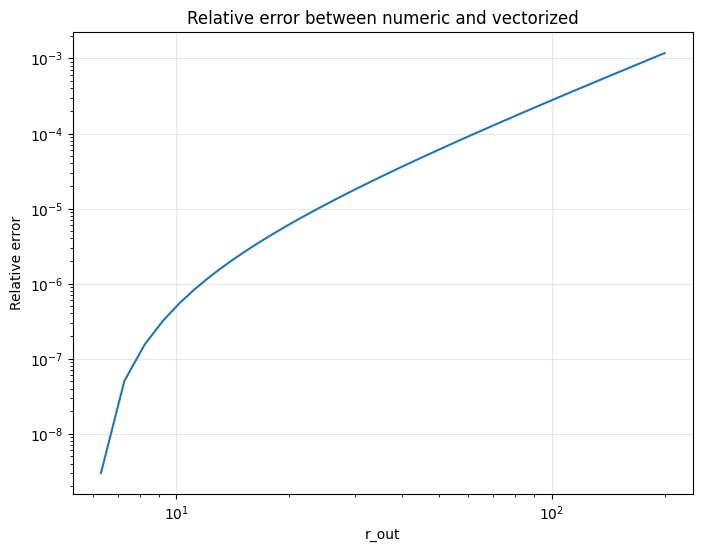

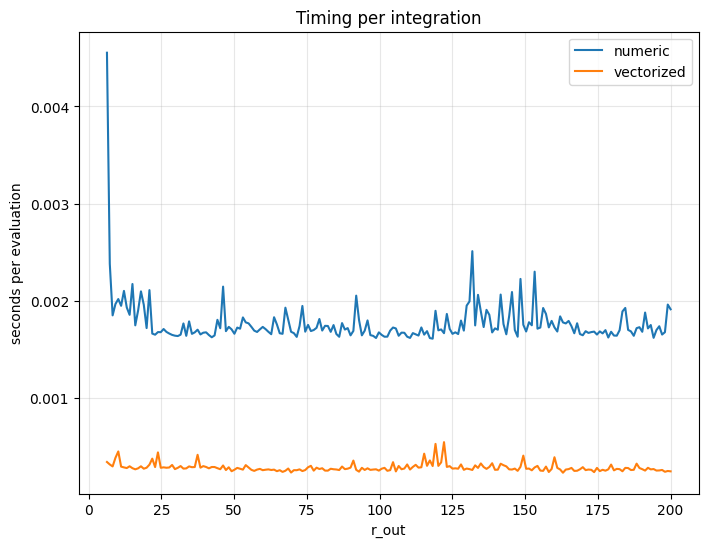

In [35]:

def nu_prec_numeric_vectorized(a, r_in, r_out, zeta, n_rad=20000):
    """
    Fully numeric, non-approximated integration — vectorized.
    a, r_in, r_out, zeta can be arrays, all broadcastable.
    Integration variable is R, but rewritten onto a normalized x-grid.
    """
    # Ensure arrays
    a = np.asarray(a)
    r_in = np.asarray(r_in)
    r_out = np.asarray(r_out)
    zeta = np.asarray(zeta)

    # Normalized radial grid
    x = np.linspace(0, 1, n_rad)
    x = x.reshape((1,)*a.ndim + (n_rad,))

    # Physical radius grid
    R = r_in[...,None] + x * (r_out - r_in)[...,None]  # shape = broadcast + (n_rad,)

    # Compute integrand
    Sigma = R**(-zeta[...,None])
    weight = Sigma * R**3 * nu_phi(R, a[...,None])

    integrand = nu_LT(R, a[...,None]) * weight

    # dR = (r_out - r_in) * dx
    dR = (r_out - r_in)[...,None]

    # integrate along x axis
    num = np.trapezoid(integrand, x, axis=-1) * dR
    den = np.trapezoid(weight,    x, axis=-1) * dR

    return num / den


# --------------------------------------------------------
# RUN BENCHMARK
# --------------------------------------------------------

nu_true2   = np.zeros_like(r_out_vals)

t_num2 = []


for i, r_out in enumerate(r_out_vals):

    # numeric
    t0 = time.perf_counter()
    nu_true2[i] = nu_prec_numeric_vectorized(a, r_in, r_out, zeta)
    t_num2.append(time.perf_counter() - t0)

# --------------------------------------------------------
# COMPUTE ERROR
# --------------------------------------------------------

rel_err2 = np.abs(nu_true2 - nu_approx) / nu_true2


# --------------------------------------------------------
# PRINT SPEEDUP
# --------------------------------------------------------

print("\nBenchmark completed")
print(f"Average numeric time:     {np.mean(t_num2):.4f} s")
print(f"Average vectorized time:  {np.mean(t_vec):.4f} s")
print(f"Speed-up factor:          {np.mean(t_num2)/np.mean(t_vec):.1f}x")


# --------------------------------------------------------
# PLOTS
# --------------------------------------------------------

plt.figure(figsize=(8,6))
plt.loglog(r_out_vals, nu_true2, label="Numeric (true)", lw=2)
plt.loglog(r_out_vals, nu_approx, "--", label="Vectorized approx", lw=2)
plt.xlabel("r_out")
plt.ylabel("ν_prec  (geometric units)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.title("Precession frequency: true vs. vectorized")
plt.show()

plt.figure(figsize=(8,6))
plt.loglog(r_out_vals, rel_err2)
plt.xlabel("r_out")
plt.ylabel("Relative error")
plt.grid(True, alpha=0.3)
plt.title("Relative error between numeric and vectorized")
plt.show()

plt.figure(figsize=(8,6))
plt.plot(r_out_vals, t_num2, label="numeric")
plt.plot(r_out_vals, t_vec, label="vectorized")
plt.xlabel("r_out")
plt.ylabel("seconds per evaluation")
plt.grid(True, alpha=0.3)
plt.legend()
plt.title("Timing per integration")
plt.show()


Benchmark completed
Average numeric time:     0.0018 s
Average vectorized time:  0.0042 s
Speed-up factor:          2.4x


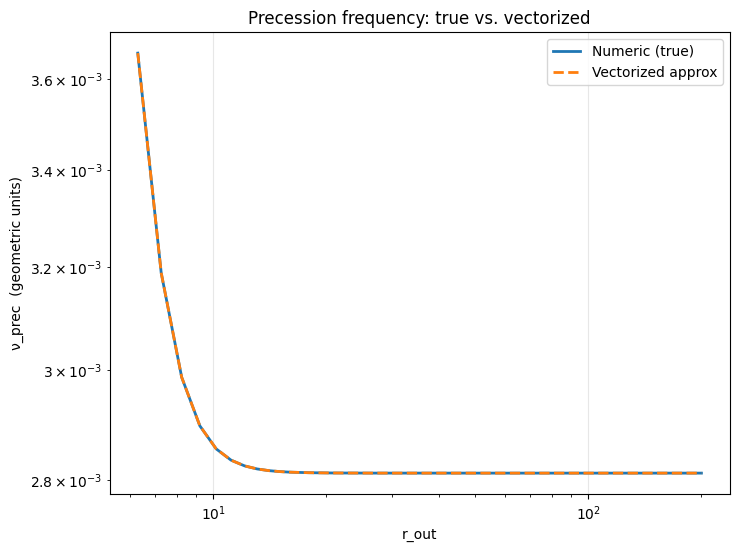

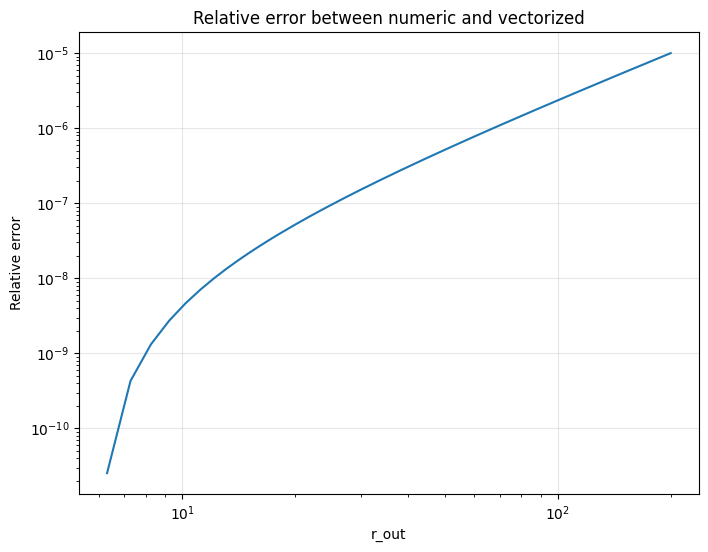

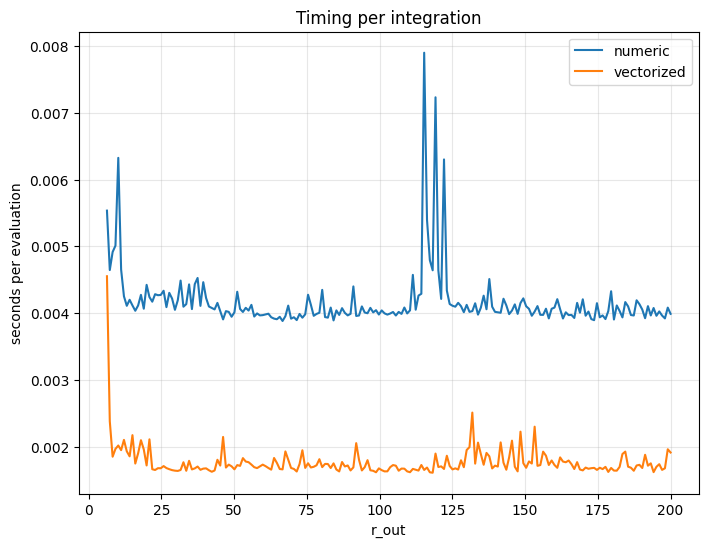

In [36]:
print("\nBenchmark completed")
print(f"Average numeric time:     {np.mean(t_num2):.4f} s")
print(f"Average vectorized time:  {np.mean(t_num):.4f} s")
print(f"Speed-up factor:          {np.mean(t_num)/np.mean(t_num2):.1f}x")

# --------------------------------------------------------
# PLOTS
# --------------------------------------------------------

plt.figure(figsize=(8,6))
plt.loglog(r_out_vals, nu_true, label="Numeric (true)", lw=2)
plt.loglog(r_out_vals, nu_true2, "--", label="Vectorized approx", lw=2)
plt.xlabel("r_out")
plt.ylabel("ν_prec  (geometric units)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.title("Precession frequency: true vs. vectorized")
plt.show()

rel_err3 = np.abs(nu_true2 - nu_true) / nu_true

plt.figure(figsize=(8,6))
plt.loglog(r_out_vals, rel_err3)
plt.xlabel("r_out")
plt.ylabel("Relative error")
plt.grid(True, alpha=0.3)
plt.title("Relative error between numeric and vectorized")
plt.show()

plt.figure(figsize=(8,6))
plt.plot(r_out_vals, t_num, label="numeric")
plt.plot(r_out_vals, t_num2, label="vectorized")
plt.xlabel("r_out")
plt.ylabel("seconds per evaluation")
plt.grid(True, alpha=0.3)
plt.legend()
plt.title("Timing per integration")
plt.show()

perché mi esce errore relativo divero da zreo tra queste due? dovrebbero essere uguali!

In [1]:
import numpy as np

def create_param_grid(param_dict, mesh=True, flatten=False):
    """
    Create an N-dimensional grid from a dictionary of parameters.
    
    param_dict : dict
        Keys = parameter names (str)
        Values = tuple/list defining the grid for each parameter.
                 Accepted formats:
                    - (min, max, n_points)
                    - array-like explicit list of values
                    
    mesh : bool
        If True, returns a meshgrid (N arrays).
        If False, only returns the 1D vectors for each parameter.

    flatten : bool
        If True, also returns a 2D array shape (N_points_total, N_params)
        useful for vectorized evaluation.

    Returns:
        param_vectors: dict of 1D arrays for each parameter
        mesh_arrays  : list of meshgrid arrays (if mesh=True)
        flat_matrix  : 2D array of flattened grid points (if flatten=True)
    """

    labels = list(param_dict.keys())
    values = []

    # Build 1D arrays for each parameter
    for key, val in param_dict.items():
        if len(val) == 3 and all(isinstance(x, (int, float)) for x in val):
            vmin, vmax, n = val
            values.append(np.linspace(vmin, vmax, n))
        else:
            # explicit array provided
            values.append(np.array(val))

    # Return only vectors
    param_vectors = {lab: vec for lab, vec in zip(labels, values)}

    if not mesh and not flatten:
        return param_vectors

    # Build meshgrid
    mesh_arrays = np.meshgrid(*values, indexing="ij")

    if not flatten:
        return param_vectors, mesh_arrays

    # Flatten meshgrid to shape (N_total, N_params)
    stacked = np.stack(mesh_arrays, axis=-1)   # shape (..., N_params)
    flat_matrix = stacked.reshape(-1, len(labels))

    return param_vectors, mesh_arrays, flat_matrix


In [36]:
params = {
    "a": (0, 0.99, 100),
    "r": (2, 300, 298),
    "M": (10**6.3, 10**6.4, 2)
}

param_vectors, mesh_arrays = create_param_grid(params)

A, R, M = mesh_arrays  # each has shape (100, 200, 40)


In [37]:
from setup import *
freq = nu_phi(R, A)


In [38]:
freq.shape  

(100, 298, 2)

In [43]:
# for efficienza: calcola r_isco per tutti a_abs (vector)
a_vec = param_vectors["a"]  # shape (N_a,)
r_isco_vec = r_isco(a_vec)  # shape (N_a,)

# costruisci mask su mesh (broadcast r_isco_vec over r_grid)
mask = R >= r_isco_vec[:, None, None]

# calcola differenza/condizione di match solo dove mask True
diff = np.abs(freq - NU0)
valid_diff = np.where(mask, diff, np.inf)

# Boolean mask of acceptable points
good = valid_diff < TOL   # shape (Na, Nr, Nm)

# Get all indices where condition is satisfied
idxs = np.argwhere(good)  # shape (N_matches, 3)

results = []

for ia, ir, iM in idxs:
    a_best = A[ia, ir, iM]
    r_best = R[ia, ir, iM]
    M_best = M[ia, ir, iM]
    f_best = freq[ia, ir, iM]

    results.append((a_best, r_best, M_best, f_best))

In [54]:
len(results)

200

In [47]:
def find_param_matches(mesh_arrays, labels, param_vectors, freq_func):
    """
    N-dimensional match finder with automatic rISCO constraints.
    
    mesh_arrays : list of ndarrays
        Meshgrid arrays from create_param_grid()
    labels : list of str
        Parameter names (same order as mesh_arrays)
    param_vectors : dict
        1D parameter vectors (output of create_param_grid)
    r_isco : callable
        Function r_isco(a)
    freq_func : callable
        freq = freq_func(param_dict)
    """

    # Assemble parameter dictionary (each is an N-D meshgrid array)
    param_dict = {lab: arr for lab, arr in zip(labels, mesh_arrays)}

    # ---- Compute frequency on full grid ----
    freq = freq_func(param_dict)

    # ---- Master mask ----
    mask = np.ones_like(freq, dtype=bool)

    # ---- Automatic rISCO constraint ----
    # 1) Get the 1D vector of a-values
    a_vec = param_vectors["a"]                  # shape (N_a,)
    r_isco_vec = r_isco(a_vec)                  # shape (N_a,)

    # 2) Create broadcastable version
    r_isco_nd = r_isco_vec.reshape(-1, *[1]*(freq.ndim - 1))

    # 3) Apply to all r-parameters
    for lab, arr in param_dict.items():
        if "r" in lab:                          # <-- automatic detection
            mask &= arr >= r_isco_nd

    # ---- Apply frequency matching ----
    mask &= np.abs(freq - NU0) < TOL

    # ---- Collect matches ----
    idxs = np.argwhere(mask)   # shape (N_matches, ndim)
    results = []

    for idx in idxs:
        params = {lab: arr[tuple(idx)] for lab, arr in param_dict.items()}

        results.append({
            "params": params,
            "freq": freq[tuple(idx)]
        })

    return results


In [49]:
import inspect

def make_general_freq_func(freq_callable):
    """
    Ritorna una funzione che accetta un dizionario di parametri
    e passa alla freq_callable solo quelli che essa richiede.
    """
    sig = inspect.signature(freq_callable)
    param_names = list(sig.parameters.keys())

    def wrapper(param_dict):
        # Estrai solo i parametri richiesti
        args = [param_dict[name] for name in param_names]
        return freq_callable(*args)

    return wrapper

freq_func = make_general_freq_func(nu_phi)


In [50]:
labels = list(params.keys())

res2 = find_param_matches(
    mesh_arrays=mesh_arrays,
    labels=labels,
    param_vectors=param_vectors,
    freq_func=freq_func
)

In [53]:
len(res2)

200